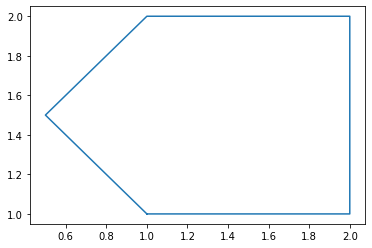

In [1]:
import matplotlib.pyplot as plt

coord = [[1,1], [2,1], [2,2], [1,2], [0.5,1.5]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.show()

In [43]:
import prestodb
conn=prestodb.dbapi.connect(
    host='localhost',
    port=9000,
    user='python',
    catalog='hive',
    schema='default',
)
cur = conn.cursor()

In [78]:
import json
import math
import shapely
import geopandas
from shapely.geometry import LineString, Point, Polygon
cur.execute("""
    with latest_timestamp as (SELECT max(timestamp) as timestamp, sourcedevice FROM cve_one_day where messagetype = 'MAP' group by sourcedevice),
    map_subset as (select * from cve_one_day where messagetype = 'MAP' order by timestamp desc limit 500),
    latest_map as (select * from latest_timestamp join map_subset using (timestamp, sourcedevice))
    
    select 
        messagebody, json_extract(messageBody, '$.intersections[0].laneWidth') as laneWidth, 
        cast(json_extract_scalar(messageBody, '$.intersections[0].refPoint.lat') as double) / 10000000 as refLat, 
        cast(json_extract_scalar(messageBody, '$.intersections[0].refPoint.long') as double) / 10000000 as refLon,
        
        transform(
               cast(json_extract(messageBody, '$.intersections[0].laneSet') AS ARRAY<JSON>),
                 x -> transform(cast(JSON_EXTRACT(x, '$.nodeList[1]') as ARRAY<JSON>),
                   y -> 
                       cast(
                           row(
                                JSON_EXTRACT_scalar(y, '$.delta[1].x'),
                                JSON_EXTRACT_scalar(y, '$.delta[1].y'),
                                JSON_EXTRACT_scalar(y, '$.attributes.dWidth'),
                                JSON_EXTRACT_scalar(x, '$.laneID'),
                                JSON_EXTRACT_scalar(x, '$.laneAttributes.laneType[0]'),
                                JSON_EXTRACT_scalar(y, '$.delta[0]'),
                                cast(JSON_EXTRACT_scalar(y, '$.delta[1].lat') as double) / 10000000,
                                cast(JSON_EXTRACT_scalar(y, '$.delta[1].lon') as double) / 10000000
                           )
                           as
                           row(
                               x varchar,
                               y varchar,
                               dWidth varchar,
                               laneID varchar,
                               laneType varchar,
                               offsetType varchar,
                               lat double,
                               lon double
                           )
                       )
                    
                   )
            ) as deltas,
        sourcedevice
    from latest_map
""")
intersections = cur.fetchall()

In [86]:
geometries = []

for intersection in intersections:
    laneWidth = float(intersection[1])
    ref_lat = float(intersection[2])
    ref_lon = float(intersection[3])
    lanes = intersection[4]
    sourceDevice = intersection[5]
    # lane = lanes[0]

#     print(sourceDevice)

    for lane in lanes:
        laneWidth = float(intersection[1])
#         print(lane)
        # print(map['intersections'][0]['laneSet'])

        prevLat = ref_lat
        prevLon = ref_lon
        lane_points = lane

        nextLat = 0
        nextLon = 0

        sizeOfList = len(lane_points)

        if lane_points[0][0] == None:
            print(f"Could not generate lane polygons for {sourceDevice}")
            continue
            
        xAdj = list(map(lambda points: int(points[0]), lane_points))
        yAdj = list(map(lambda points: int(points[1]), lane_points))
        laneWidthAdj = list(map(lambda points: points[2], lane_points))

        laneR = []
        laneL = []
#         print(lane_points)
        for i, point in enumerate(lane_points):
            nextLat = prevLat + (yAdj[i]/100) / 111111
            nextLon = prevLon + (xAdj[i]/100) / (111111 * math.cos(prevLat * math.pi / 180))

            if (laneWidthAdj[i]):
                laneWidth = laneWidth + float(laneWidthAdj[i])
#                 print(f"Adjusting lane width by {laneWidthAdj[i]} to {laneWidth}")

            if (i < sizeOfList-1):
                bearing1 = math.atan(yAdj[i+1] / xAdj[i+1]) + math.pi/2
                bearing2 = math.atan(yAdj[i+1] / xAdj[i+1]) - math.pi/2
            else:
                bearing1 = math.atan(yAdj[i] / xAdj[i]) + math.pi/2
                bearing2 = math.atan(yAdj[i] / xAdj[i]) - math.pi/2

            xAdjR = math.cos(bearing1) * (laneWidth/2)
            yAdjR = math.sin(bearing1) * (laneWidth/2)
            xAdjL = math.cos(bearing2) * (laneWidth/2)
            yAdjL = math.sin(bearing2) * (laneWidth/2)

            laneRY = nextLat + (yAdjR/100) / 111111
            laneRX = nextLon + (xAdjR/100) / (111111 * math.cos(nextLat * math.pi / 180))
            laneR.append((laneRX, laneRY))

            laneLY = nextLat + (yAdjL/100) / 111111
            laneLX = nextLon + (xAdjL/100) / (111111 * math.cos(nextLat * math.pi / 180))
            laneL.append((laneLX, laneLY))

            if (i > 0):
                line1 = LineString(laneR)
                line2 = LineString(laneL)

                if line1.intersects(line2):
                    left = laneL.pop()
                    right = laneR.pop()
                    laneR.append(left)
                    laneL.append(right)

            prevLat = nextLat
            prevLon = nextLon

        laneR.reverse()
    #     print(laneR + laneL)

        coord = laneL + laneR
        geometries.append({'geometry': coord, 'laneID': lane_points[0][3], 'laneType': lane_points[0][4], 'sourceDevice': sourceDevice})
    #     coord.append(coord[0]) #repeat the first point to create a 'closed loop'

    #     xs, ys = zip(*coord) #create lists of x and y values

    #     plt.figure()
    #     plt.plot(xs,ys) 
#         plt.show()

Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cleveland_oaklandpark_cvcp
Could not generate lane polygons for cle

In [88]:
import plotly.express as px
for lane in geometries:
    lane.update({'geometry': shapely.geometry.Polygon(lane['geometry'])})

geo_df = geopandas.GeoDataFrame(geometries)

fig = px.choropleth_mapbox(geo_df,
                           geojson=geo_df.geometry,
                           locations=geo_df.index,
                           color_continuous_scale="Light24",
                           center={"lat": 40.0633, "lon": -82.9772},
                           color='laneType',
                           opacity=0.75,
                           zoom=14.5)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken="pk.eyJ1Ijoic21ydGNidXMiLCJhIjoiY2ptMTB6YjIzMGVuazNwcWcyczk3a2ZmNSJ9.SjVhquTC7K5RzbGqoGZUYg")
fig.show()

geo_df


geometry laneID   laneType  \
0     POLYGON ((-82.89516 40.05687, -82.89536 40.056...    117    vehicle   
1     POLYGON ((-82.89517 40.05684, -82.89536 40.056...    116    vehicle   
2     POLYGON ((-82.89519 40.05681, -82.89560 40.056...    115    vehicle   
3     POLYGON ((-82.89519 40.05677, -82.89588 40.056...    114    vehicle   
4     POLYGON ((-82.89519 40.05674, -82.89588 40.056...    113    vehicle   
...                                                 ...    ...        ...   
1043  POLYGON ((-83.02030 40.05143, -83.02037 40.051...    115    vehicle   
1044  POLYGON ((-83.02021 40.05153, -83.02003 40.051...     23  crosswalk   
1045  POLYGON ((-83.01994 40.05146, -83.01995 40.051...     52  crosswalk   
1046  POLYGON ((-83.02003 40.05128, -83.02022 40.051...     87  crosswalk   
1047  POLYGON ((-83.02024 40.05137, -83.02022 40.051...    117  crosswalk   

             sourceDevice  
0      morse_lbrands_cvcp  
1      morse_lbrands_cvcp  
2      morse_lbrands_cvcp  
3      morse_lbrands_cvcp  
4      morse_lbrands_cvcp  
...                   ...  
1043  high_henderson_cvcp  
1044  high_henderson_cvcp  
1045  high_henderson_cvcp  
1046  high_henderson_cvcp  
1047  high_henderson_cvcp  

[1048 rows x 4 columns]